### SingleCellRNA dataset visualization

unzip the 'pbmc_1_counts.csv.zip' to get the SingleCellRNA dataset

CIR......


/nas/longleaf/home/myueen/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/home/myueen/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d544795a0>
Traceback (most recent call last):
  File "/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.

---------------------------------------------------

Results for Scaled Gradient Projection Method 

---------------------------------------------------

   Obj. function = -2.834427e+03

   Gradient norm = 1.541518e-01 

   ||X^T*X-I||_F = 4.59e-16

   Iteration number = 3000

   Cpu time (secs) = 1.6448

   Number of evaluation(Obj. func) = 3262

SIR...
PCA...
CPCA...
t-SNE...
UMAP...
LDA...
LASSO...


/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.769e+00, tolerance: 9.348e-01
  model = cd_fast.enet_coordinate_descent(


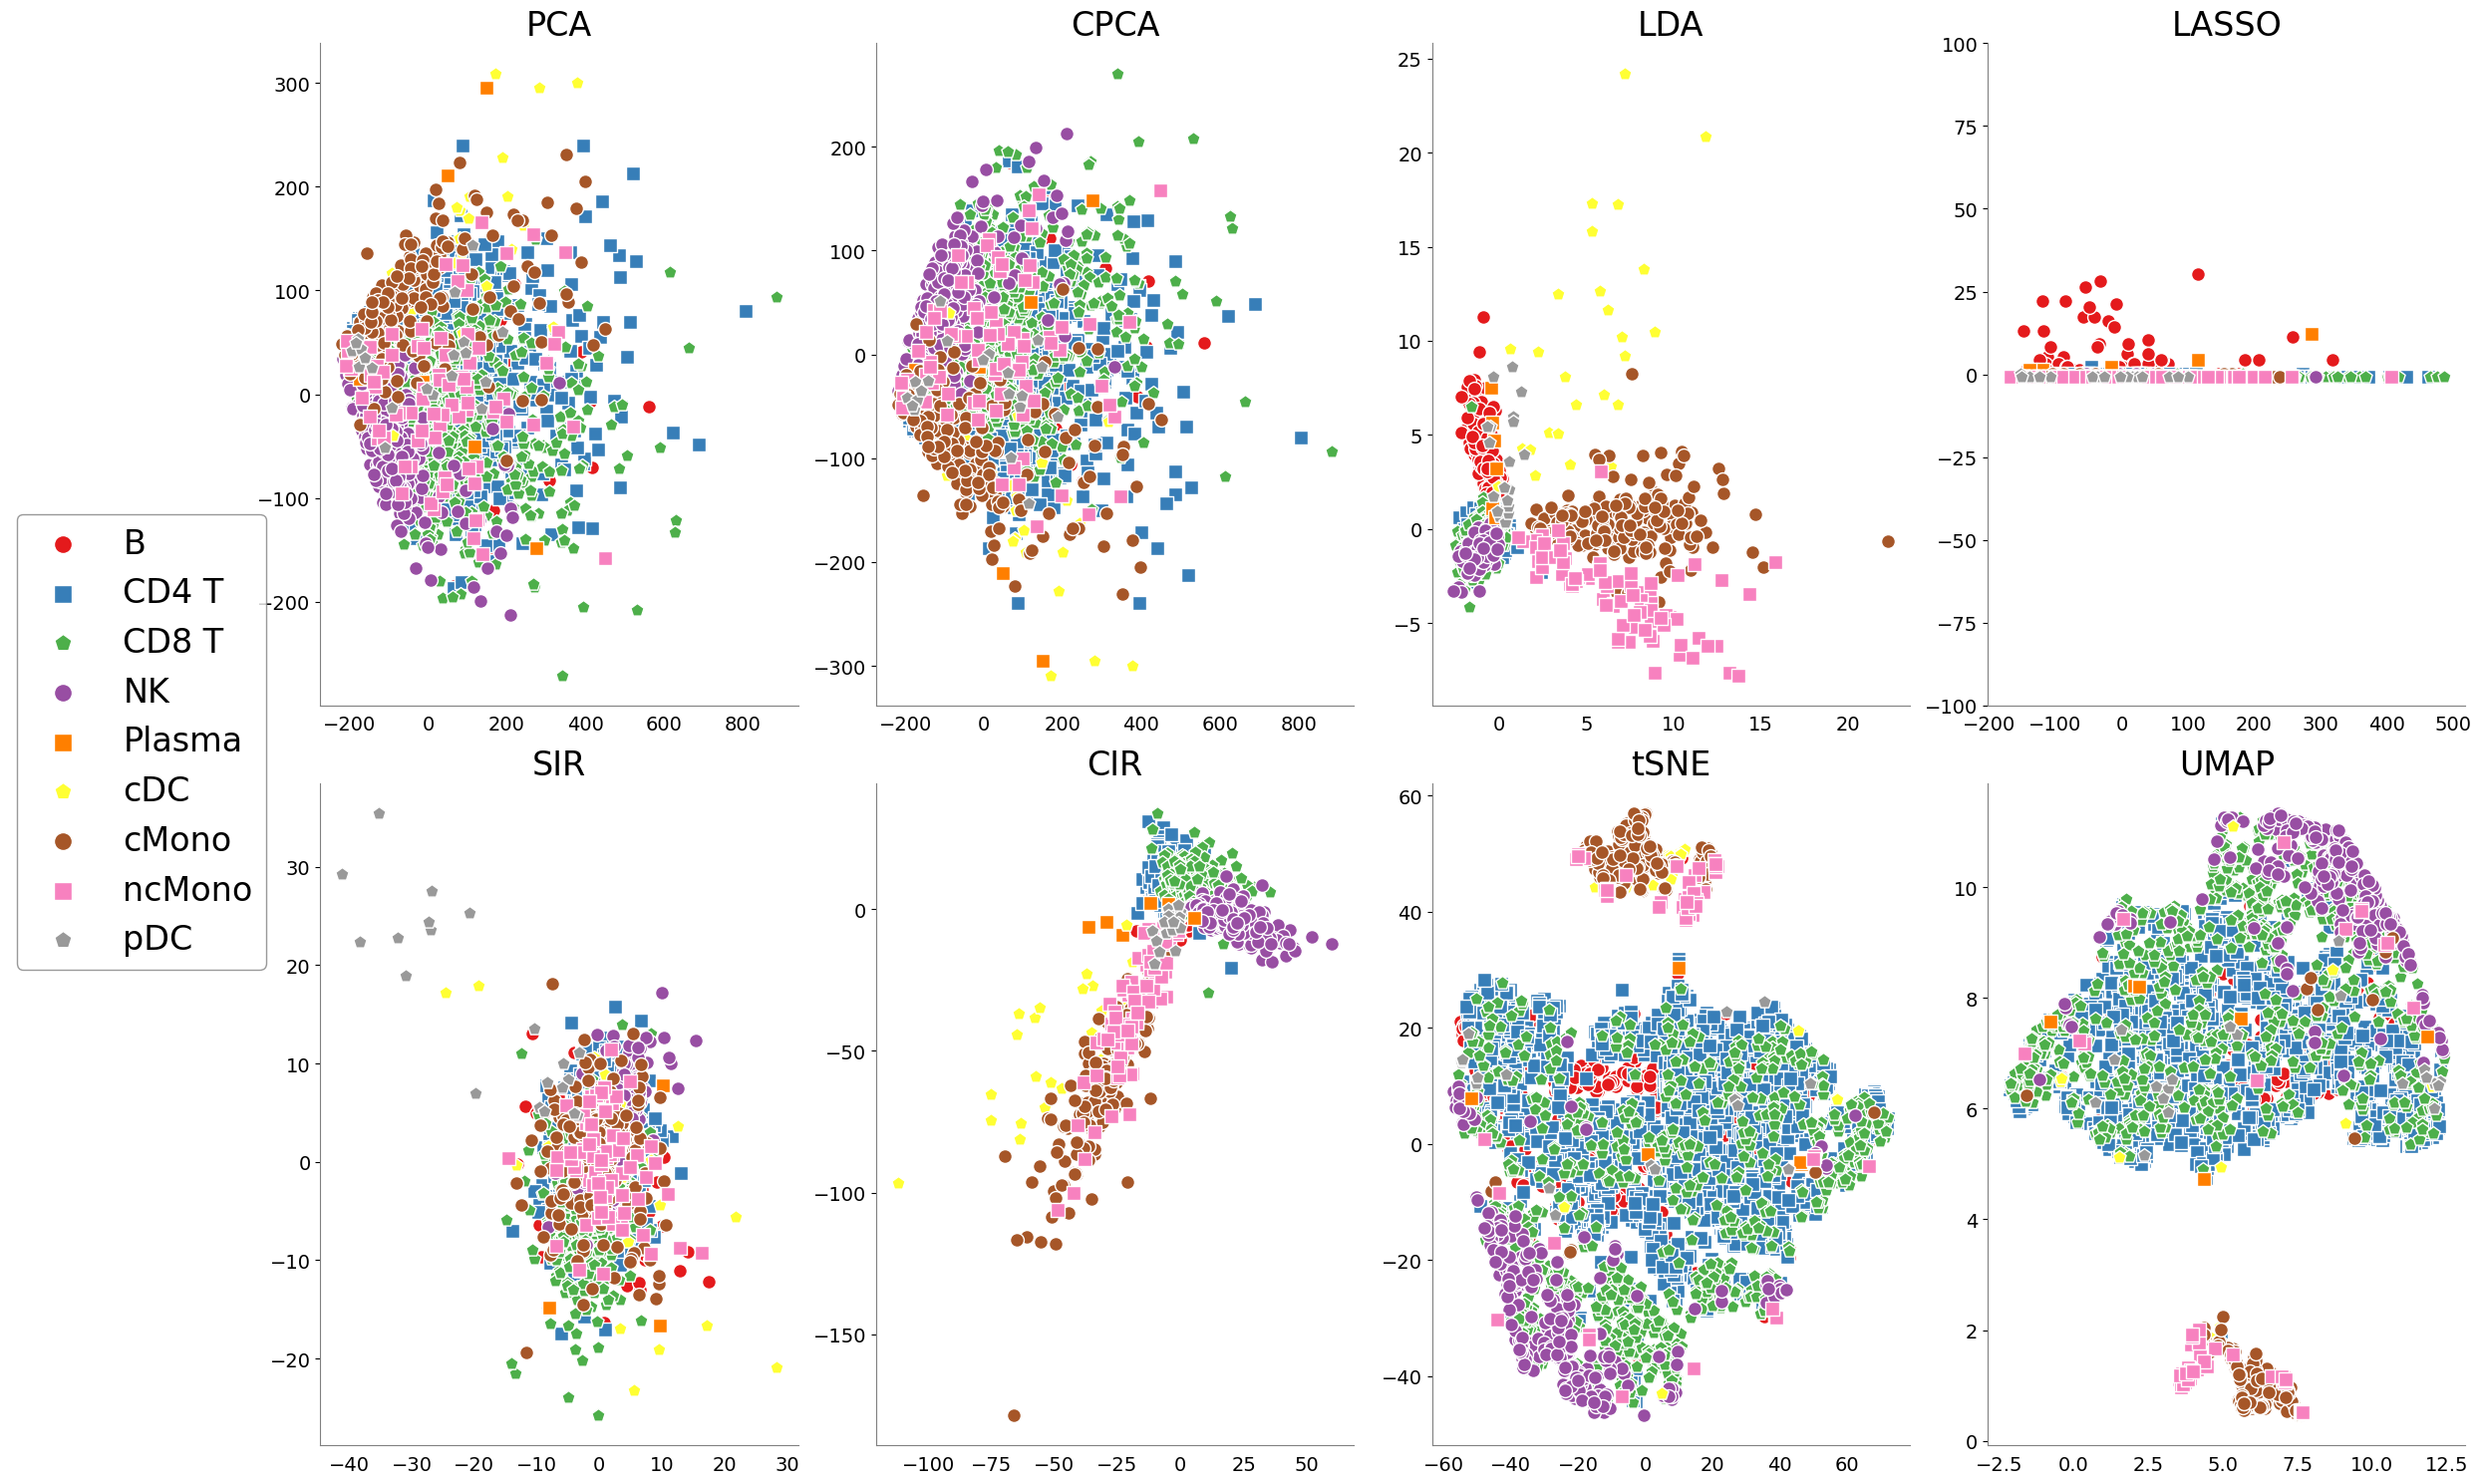

  Method  Silhouette Score  Calinski Harabasz Score  Davies Bouldin Score
0    PCA         -0.130653                47.718305              6.539509
1   CPCA         -0.130653                47.718305              6.539509
2    LDA          0.086057              1507.871943              3.805451
3  LASSO         -0.195934                38.486673             18.224641
4    SIR         -0.058761               109.055680             11.914829
5    CIR          0.118263              1484.360013              1.646901
6   tSNE         -0.100991               133.209293              5.824385
7   UMAP         -0.086856               147.794042              6.871132
Time taken to run the code: 40.57166600227356 seconds


In [8]:
import numpy as np
import pandas as pd
import time
import matplotlib
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.metrics import silhouette_score
from scipy.linalg import eig
import umap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import contrastive_inverse_regression
from contrastive_inverse_regression import CIR



start_time = time.time()

data = pd.read_csv('datasets/pbmc_1_counts.csv')
data = data.iloc[:, 1:]
data = data.transpose()


cell_type = pd.read_csv('datasets/pbmc_1_cell_type.csv')
cell_type = cell_type.iloc[:, 1].values


# foreground data
fg = data.dropna()


p = 100     # p can vary from 100 to 500
# select the top p highly variable genes
col_var = np.var(fg, axis=0)
col_var_sorted_idx = np.argsort(-col_var)
fg = fg.iloc[:, col_var_sorted_idx[:p]]


# foreground label: cell types
Y = cell_type
Y = pd.Categorical(Y)
Y = Y.rename_categories({'B cell': '0', 'CD4 T cell': '1', 'CD8 T cell': '2', 'NK cell': '3',
                        'Plasma cell': '4', 'cDC': '5', 'cMono': '6', 'ncMono': '7', 'pDC': '8'})
Y = Y.astype(float)
labels = np.unique(Y)      # set of unique foreground labels
L = len(labels)         # number of foreground classes/slices
n = fg.shape[0]  # foreground sample size
X = fg - np.mean(fg, axis=0)
X = X.values



# background data
bg = fg
m, p = bg.shape  # background sample size
Yt = 3 * np.ones((m, 1))  # background labels
Yt = np.random.randint(1, 10, size=(m, 1))



# tuning parameter
alpha = 1.5
d = 2


np.random.seed(24)      # add seed


# CIR
print("CIR......")
V_CIR = CIR(fg, Y, bg, Yt, alpha, d)
X_CIR = X @ V_CIR


# SIR
print("SIR...")
Sigma_XX = X.T @ X / n
Sigma_X = np.zeros((p, p))
for l in range(L):
   X_curr = fg.values[Y == l]
   n_curr = X_curr.shape[0]
   Sigma_X += n_curr * np.outer(X_curr.mean(axis=0) - fg.values.mean(axis=0), X_curr.mean(axis=0) - fg.values.mean(axis=0))


Sigma_X /= n
eigvals, eigvecs = scipy.linalg.eig(Sigma_XX, Sigma_X)
V_SIR = eigvecs[:, :d]
X_SIR = X @ V_SIR



# PCA
print("PCA...")
pca = PCA(n_components=d)
X_PCA = pca.fit_transform(X)


# CPCA
print("CPCA...")
alpha_CPCA = 2
cov_fg = np.cov(fg.values, rowvar=False)
cov_bg = np.cov(bg.values, rowvar=False)
eigvals, eigvecs = eigh(cov_fg - alpha_CPCA * cov_bg)
V_CPCA = eigvecs[:, :d]
X_CPCA = X @ V_CPCA



# t-SNE
print("t-SNE...")
tsne = TSNE(n_components=d)
X_tSNE = tsne.fit_transform(fg.values)


# UMAP
print("UMAP...")
umap_model = umap.UMAP(n_components=d)
X_UMAP = umap_model.fit_transform(fg.values)


# LDA
print("LDA...")
lda = LDA(n_components=d)
X_LDA = lda.fit_transform(X, Y)


# LASSO
print("LASSO...")
lasso = Lasso(alpha=0.1)
lasso.fit(X, Y)
selected_features = np.where(lasso.coef_ != 0)[0][:d]
X_LASSO = X[:, selected_features]


# colors credit to Color Brewer
colors = [[228/255, 26/255, 28/255],
         [55/255, 126/255, 184/255],
         [77/255, 175/255, 74/255],
         [152/255, 78/255, 163/255],
         [255/255, 127/255, 0/255],
         [255/255, 255/255, 51/255],
         [166/255, 86/255, 40/255],
         [247/255, 129/255, 191/255],
         [153/255, 153/255, 153/255]]


markers = ['o', 's', 'p', 'o', 's', 'p', 'o', 's', 'p']
legend_labels = [
    'B', 'CD4 T', 'CD8 T', 'NK', 
    'Plasma', 'cDC', 'cMono', 'ncMono', 'pDC'
]


fig, axs = plt.subplots(2, 4, figsize=(25, 15))

def plot_scatter(ax, X, title, fontsize=32, ylim=None):
    for l in range(L):
       X_curr = X[Y == labels[l]]
       ax.scatter(X_curr[:, 0], X_curr[:, 1], 100, color=colors[l], marker=markers[l], label=f'Label {labels[l]}', edgecolors='w')
    
    ax.tick_params(axis='both', which='major', bottom=False, top=False, left=True, right=False,
                labelleft=True, labelbottom=True, labelsize=14)
    ax.set_title(title, fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    if ylim:
       ax.set_ylim(ylim)


# Plotting each subplot
plot_scatter(axs[0, 0], X_PCA, 'PCA', 24)
plot_scatter(axs[0, 1], X_CPCA, 'CPCA', 24)
plot_scatter(axs[0, 2], X_LDA, 'LDA', 24)
plot_scatter(axs[0, 3], X_LASSO, 'LASSO', 24, ylim=(-100, 100))
plot_scatter(axs[1, 0], X_SIR, 'SIR', 24)
plot_scatter(axs[1, 1], X_CIR, 'CIR', 24)
plot_scatter(axs[1, 2], X_tSNE, 'tSNE', 24)
plot_scatter(axs[1, 3], X_UMAP, 'UMAP', 24)

# Create a legend
fig.legend(legend_labels, loc='center left', fontsize=24, markerscale=1.3, frameon=True, edgecolor='grey')

plt.tight_layout(rect=[0.1, 0, 1, 1])
plt.show()



# print('Silhouette scores for PCA, CPCA, LDA, LASSO, SIR, CIR, tSNE, UMAP')
silhouette_scores = [
   silhouette_score(X_PCA, Y),
   silhouette_score(X_CPCA, Y),
   silhouette_score(X_LDA, Y),
   silhouette_score(X_LASSO, Y),
   silhouette_score(X_SIR, Y),
   silhouette_score(X_CIR, Y),
   silhouette_score(X_tSNE, Y),
   silhouette_score(X_UMAP, Y),
]

# print('Calinski Harabasz scores for PCA, CPCA, LDA, LASSO, SIR, CIR, tSNE, UMAP')
calinski_harabasz_scores = [
    calinski_harabasz_score(X_PCA, Y),
    calinski_harabasz_score(X_CPCA, Y),
    calinski_harabasz_score(X_LDA, Y),
    calinski_harabasz_score(X_LASSO, Y),
    calinski_harabasz_score(X_SIR, Y),
    calinski_harabasz_score(X_CIR, Y),
    calinski_harabasz_score(X_tSNE, Y),
    calinski_harabasz_score(X_UMAP, Y),
]


# print('Davies Bouldin scores for PCA, CPCA, LDA, LASSO, SIR, CIR, tSNE, UMAP')
davies_bouldin_scores = [
    davies_bouldin_score(X_PCA, Y),
    davies_bouldin_score(X_CPCA, Y),
    davies_bouldin_score(X_LDA, Y),
    davies_bouldin_score(X_LASSO, Y),
    davies_bouldin_score(X_SIR, Y),
    davies_bouldin_score(X_CIR, Y),
    davies_bouldin_score(X_tSNE, Y),
    davies_bouldin_score(X_UMAP, Y),
]


methods = ['PCA', 'CPCA', 'LDA', 'LASSO', 'SIR', 'CIR', 'tSNE', 'UMAP']
scores_df = pd.DataFrame({
    'Method': methods,
    'Silhouette Score': silhouette_scores,
    'Calinski Harabasz Score': calinski_harabasz_scores,
    'Davies Bouldin Score': davies_bouldin_scores, 
})


print(scores_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to run the code: {elapsed_time} seconds")